In [1]:
import anndata as ad
import pandas as pd

import metacells as mc
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("white")

/home/jkaatz/miniforge3/envs/r_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
full = ad.read_h5ad('../../data/daniocell_gastrulation.h5ad')
cell_type = pd.read_csv('../../data/forseurat_celltypes.csv')
cell_type.index = full.obs.index
full.obs['cell_type_old'] = cell_type

In [3]:
def convey_cell_annotations_to_metacells(metacells = None):
    to_save = metacells.copy()
    to_save.obs = (
        to_save.obs
        .merge((
            (cells.obs[["hpf", "metacell_name"]])
            .groupby("metacell_name", observed=True)["hpf"]
            .agg(pd.Series.mean)
        ), left_index=True, right_index=True)
        .merge((
            (cells.obs[["cell_type_old", "metacell_name"]])
            .groupby("metacell_name", observed=True)["cell_type_old"]
            .agg(lambda x: pd.Series.mode(x)[0])
            .astype("category")
        ), left_index=True, right_index=True)
    )
    return to_save

In [4]:
mc.ut.set_name(full, 'daniocell_gastrulation_stage')
print(full.shape)

(38731, 36250)


In [5]:
excluded_genes = [
    'NC-002333.1', 'NC-002333.2', 'NC-002333.3', 'NC-002333.4', 'NC-002333.5',
    'NC-002333.6', 'NC-002333.7', 'NC-002333.8', 'NC-002333.9', 'NC-002333.10',
    'NC-002333.11', 'NC-002333.12', 'NC-002333.13', 'NC-002333.14', 'NC-002333.15',
    'NC-002333.16', 'NC-002333.17', 'NC-002333.18', 'NC-002333.19', 'NC-002333.20',
    'NC-002333.21', 'NC-002333.22', 'NC-002333.23', 'NC-002333.24'
]

excluded_gene_patterns = ['^NC-.*','^mt-.*']

In [6]:
# tests automatically for bursty lonely genes
mc.pl.exclude_genes(adata=full,
                    excluded_gene_names=excluded_genes,
                    excluded_gene_patterns= excluded_gene_patterns,
                    random_seed=123456)

set daniocell_gastrulation_stage.var[bursty_lonely_gene]: 0 true (0%) out of 36250 bools
set daniocell_gastrulation_stage.var[properly_sampled_gene]: 28862 true (79.62%) out of 36250 bools
set daniocell_gastrulation_stage.var[excluded_gene]: 7417 true (20.46%) out of 36250 bools


In [7]:
from collections import Counter
Counter(full.var.excluded_gene)

Counter({False: 28833, True: 7417})

<timed exec>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



Will exclude 30 (0.08%) cells with less than 1500 UMIs
Will exclude 1820 (4.70%) cells with more than 15000 UMIs
CPU times: user 24.6 s, sys: 13.8 ms, total: 24.7 s
Wall time: 247 ms


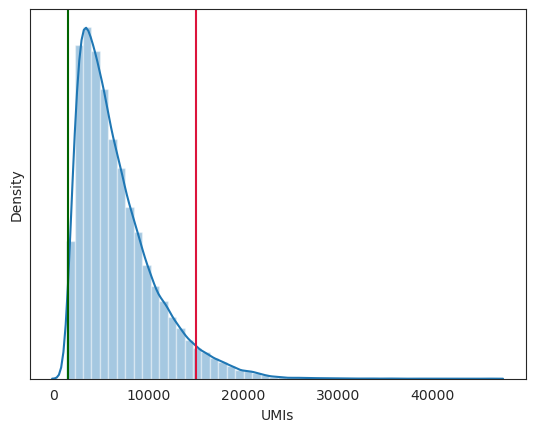

In [8]:
%%time
properly_sampled_min_cell_total = 1500
properly_sampled_max_cell_total = 15000

total_umis_of_cells = mc.ut.get_o_numpy(full, name='__x__', sum=True)

plot = sb.distplot(total_umis_of_cells)
plot.set(xlabel='UMIs', ylabel='Density', yticks=[])
plot.axvline(x=properly_sampled_min_cell_total, color='darkgreen')
plot.axvline(x=properly_sampled_max_cell_total, color='crimson')

too_small_cells_count = sum(total_umis_of_cells < properly_sampled_min_cell_total)
too_large_cells_count = sum(total_umis_of_cells > properly_sampled_max_cell_total)

too_small_cells_percent = 100.0 * too_small_cells_count / len(total_umis_of_cells)
too_large_cells_percent = 100.0 * too_large_cells_count / len(total_umis_of_cells)

print(f"Will exclude %s (%.2f%%) cells with less than %s UMIs"
      % (too_small_cells_count,
         too_small_cells_percent,
         properly_sampled_min_cell_total))
print(f"Will exclude %s (%.2f%%) cells with more than %s UMIs"
      % (too_large_cells_count,
         too_large_cells_percent,
         properly_sampled_max_cell_total))

<timed exec>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



Will exclude 1176 (3.04%) cells with more than 35.00% excluded gene UMIs
CPU times: user 24.3 s, sys: 16.1 ms, total: 24.3 s
Wall time: 196 ms


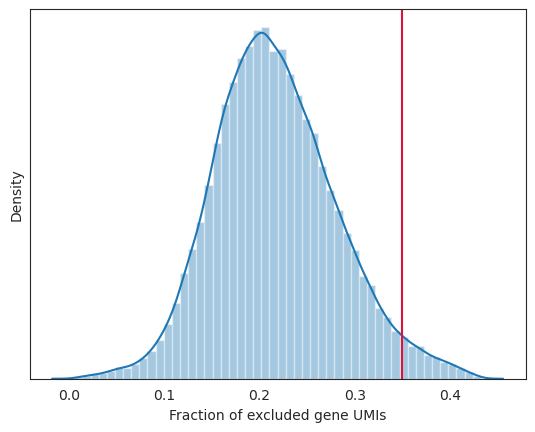

In [9]:
%%time
properly_sampled_max_excluded_genes_fraction = 0.35

excluded_genes_data = mc.tl.filter_data(full, var_masks=['&excluded_gene'])[0]
excluded_umis_of_cells = mc.ut.get_o_numpy(excluded_genes_data, name='__x__', sum=True)
excluded_fraction_of_umis_of_cells = excluded_umis_of_cells / total_umis_of_cells

plot = sb.distplot(excluded_fraction_of_umis_of_cells)
plot.set(xlabel='Fraction of excluded gene UMIs', ylabel='Density', yticks=[])
plot.axvline(x=properly_sampled_max_excluded_genes_fraction, color='crimson')

too_excluded_cells_count = sum(excluded_fraction_of_umis_of_cells > properly_sampled_max_excluded_genes_fraction)

too_excluded_cells_percent = 100.0 * too_excluded_cells_count / len(total_umis_of_cells)

print(f"Will exclude %s (%.2f%%) cells with more than %.2f%% excluded gene UMIs"
      % (too_excluded_cells_count,
         too_excluded_cells_percent,
         100.0 * properly_sampled_max_excluded_genes_fraction))

In [10]:
%%time
mc.pl.exclude_cells(adata=full,
                    properly_sampled_min_cell_total=properly_sampled_min_cell_total,
                    properly_sampled_max_cell_total=properly_sampled_max_cell_total,
                    properly_sampled_max_excluded_genes_fraction=properly_sampled_max_excluded_genes_fraction)

set daniocell_gastrulation_stage.obs[excluded_umis]: 38731 float32s
set daniocell_gastrulation_stage.obs[properly_sampled_cell]: 35705 true (92.19%) out of 38731 bools
set daniocell_gastrulation_stage.obs[excluded_cell]: 3026 true (7.813%) out of 38731 bools


CPU times: user 79.2 ms, sys: 27.6 ms, total: 107 ms
Wall time: 13.2 ms


In [11]:
clean = mc.pl.extract_clean_data(adata=full)
cells = clean

set daniocell_gastrulation_stage.clean.obs[full_cell_index]: 35705 int32s
set daniocell_gastrulation_stage.clean.var[full_gene_index]: 28833 int32s


In [12]:
%%time
base_lateral_gene_names = ["cdk1","mcm2","mcm7","rrm2","cenpa","cdc6","ccnf","cdca4","ccnd1",    # cell cycle related
"hmgb1b","hmgb3a", # not sure 
'npm1a',   # from experience in mouse data correlated with stress-related genes
"hspd1","hspa9","hsp90ab1", # stress-related
"hnrnpaba","cirbpb", # highly expressed, maybe some time-dependence but no strong cell-type-specificity
"mki67","cenpf","top2a","smc4","ube2c_1","ube2c_2","cdk1","ccnb1","ankrd11","tpx2","aurka","smc2","cenpe","pcna","mcm5","mcm4","mcm7","mcm2","orc6","tipin" ## cell cycle
]
base_lateral_gene_patterns = [ 'mcm[0-9].+', 'smc[0-9].+','hist1*.', 'hsp90.+' , 'cox.+','^rp[l|s].+','^hsp']

mc.tl.find_named_genes(cells,
                       names=base_lateral_gene_names,
                       patterns=base_lateral_gene_patterns,
                       to="lateral_gene"
)

base_lateral_gene_mask = mc.ut.get_v_numpy(clean, "lateral_gene")
base_lateral_gene_names = set(clean.var_names[base_lateral_gene_mask])
print(sorted([name for name in base_lateral_gene_names if not name.startswith("rpl") and not name.startswith("rps")]))
print(f"""and {len([

    name for name in base_lateral_gene_names if name.startswith("rpl") or name.startswith("rps")

])} rp[ls].* genes""")

set daniocell_gastrulation_stage.clean.var[lateral_gene]: 163 true (0.5653%) out of 28833 bools


['COX3', 'COX5B', 'COX7A2', 'RPL37A', 'ankrd11', 'aurka', 'ccnb1', 'ccnd1', 'ccnf', 'cdc6', 'cdca4', 'cdk1', 'cenpe', 'cenpf', 'cirbpb', 'cox10', 'cox11', 'cox14', 'cox15', 'cox16', 'cox17', 'cox18', 'cox19', 'cox20', 'cox4i1', 'cox4i1l', 'cox4i2', 'cox5aa', 'cox5ab', 'cox5b2', 'cox6a1', 'cox6a2', 'cox6b1', 'cox6b2', 'cox6c', 'cox7a1', 'cox7a2a', 'cox7a2l', 'cox7b', 'cox7c', 'cox8a', 'cox8b', 'hmgb1b', 'hmgb3a', 'hnrnpaba', 'hsp90aa1.1', 'hsp90aa1.2', 'hsp90ab1', 'hsp90b1', 'hspa9', 'hspd1', 'mcm10', 'mcm2', 'mcm3ap', 'mcm3l', 'mcm4', 'mcm5', 'mcm6l', 'mcm7', 'mki67', 'npm1a', 'orc6', 'pcna', 'smc1a', 'smc1al', 'smc1b', 'smc2', 'smc4', 'tipin', 'top2a', 'tpx2']
and 92 rp[ls].* genes
CPU times: user 16.9 ms, sys: 10 μs, total: 16.9 ms
Wall time: 15.6 ms


In [13]:
%%time
mc.pl.relate_to_lateral_genes(cells, random_seed=123456)

set daniocell_gastrulation_stage.clean.var[lateral_genes_module]: 24705 outliers (85.68%) and 4128 grouped (14.32%) out of 28833 int32 elements with 111 groups with mean size 37.19
set daniocell_gastrulation_stage.clean.varp[lateral_genes_similarity]: csr_matrix 28833 X 28833 float32s (17040384 > 0, 2.05%)


CPU times: user 4min 21s, sys: 4.29 s, total: 4min 25s
Wall time: 18.9 s


In [14]:
%%time

module_per_gene = mc.ut.get_v_series(cells, "lateral_genes_module")
base_lateral_gene_modules = np.unique(module_per_gene.values[base_lateral_gene_mask])
base_lateral_gene_modules = set(base_lateral_gene_modules[base_lateral_gene_modules >= 0])

genes_per_module = np.unique(module_per_gene.values, return_counts=True)[1][1:]
similarity_of_modules = mc.ut.get_vv_proper(cells, "lateral_genes_similarity")
similarity_of_modules = mc.ut.sum_groups(similarity_of_modules, module_per_gene.values, per="row")[0]
similarity_of_modules = mc.ut.to_layout(similarity_of_modules, layout="column_major")
similarity_of_modules = mc.ut.sum_groups(similarity_of_modules, module_per_gene.values, per="column")[0]
similarity_of_modules /= genes_per_module[:, np.newaxis] * genes_per_module[np.newaxis, :]

module_names = [
    f"(*) {gene_module}" if gene_module in base_lateral_gene_modules else str(gene_module)
    for gene_module in range(np.max(module_per_gene.values) + 1)
]

similarity_of_modules = pd.DataFrame(similarity_of_modules, index=module_names, columns=module_names)

CPU times: user 433 ms, sys: 3.32 s, total: 3.75 s
Wall time: 17 s


In [15]:
module_of_genes = clean.var['lateral_genes_module']
suspect_gene_modules = np.unique(module_of_genes[base_lateral_gene_mask])
suspect_gene_modules = suspect_gene_modules[suspect_gene_modules >= 0]
print(suspect_gene_modules)

[  0   4   6  10  14  15  19  25  29  33  36  39  45  46  47  48  49  50
  53  54  55  60  62  65  70  73  74  75  76  77  78  81  85  86  87  91
  93  95 100 102 104 106 107 108]


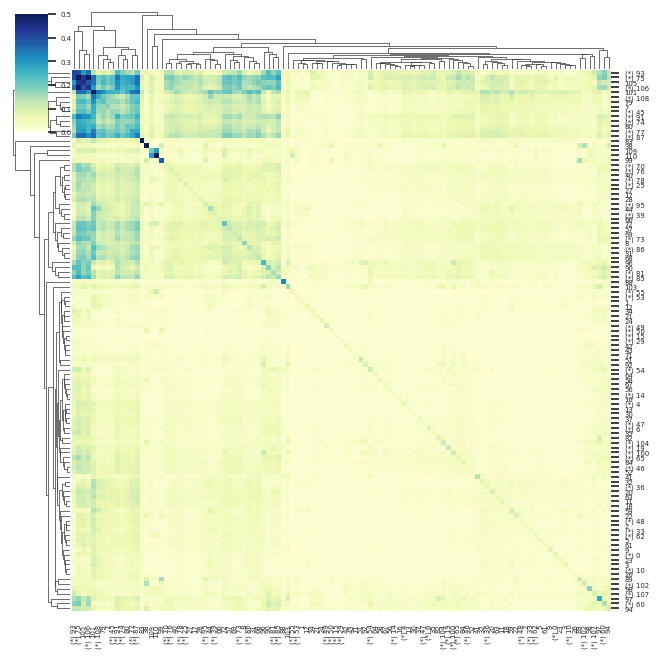

In [16]:
size = similarity_of_modules.shape[0]
if size > 50:
    sb.set(font_scale=50 / size)
    
size = size * 0.05 + 1



cm = sb.clustermap(
    similarity_of_modules,
    figsize=(size, size),
    vmin=0, vmax=0.5,
    xticklabels=True, yticklabels=True,
    dendrogram_ratio=0.1,
    cmap="YlGnBu",
)

plt.show()
sb.set(font_scale=1.0)

In [17]:
%%time

SHOW_CORRELATED_MODULES = 0.2 # Show non-lateral modules if correlated to lateral modules.

MIN_SIMILARITY_TO_SHOW = 0.2 # Show modules only if there's at least this correlation

 

base_lateral_gene_modules = np.unique(module_per_gene.values[base_lateral_gene_mask])

base_lateral_gene_modules = base_lateral_gene_modules[base_lateral_gene_modules >= 0]

similarity_of_genes = mc.ut.get_vv_frame(cells, "lateral_genes_similarity")

CPU times: user 55.1 ms, sys: 279 ms, total: 334 ms
Wall time: 332 ms


In [18]:
%%time
forbidden_genes_mask = base_lateral_gene_mask

additional_forbidden_genes = ['histh1l','uba52','naca','rack1']
additional_forbidden_gene_mask = [x in additional_forbidden_genes for x in cells.var_names]

forbidden_genes_mask = forbidden_genes_mask | additional_forbidden_gene_mask
#forbidden_genes_mask = additional_forbidden_gene_mask

for gene_module in [15,19,49,72,75,81,85,88,91,94]:
    module_genes_mask = module_per_gene.values == gene_module
    forbidden_genes_mask = forbidden_genes_mask | module_genes_mask


forbidden_gene_names = cells.var_names[forbidden_genes_mask]

forbidden_gene_names = sorted(forbidden_gene_names)
print(len(forbidden_gene_names))
print(' '.join(forbidden_gene_names))

397
CABZ01076667.1 COX3 COX5B COX7A2 CR407701.1 FQ323156.1 LOC569982 RPL37A actr5 acvr2ba adnp2a alcama aldh18a1 aldh9a1a.1 ankrd11 anxa5b api5 arhgap19 armc1l arpc3 arpc4l aspm atp5f1d atp5f1e atp5l atp5mc3b atp5mf atp5pb atp5pd atp5pf atp5po aurka aurkb baz1b bcam birc5a brd4 bsg bzw1a calm2a calm2b camlg canx ccdc9 ccnb1 ccnd1 ccnf ccng1 cd151l cd81a cdc6 cdca4 cdca8 cdk1 cdkn1a cenpe cenpf cfap298 chaf1a cirbpa cirbpb ckap2l cox10 cox11 cox14 cox15 cox16 cox17 cox18 cox19 cox20 cox4i1 cox4i1l cox4i2 cox5aa cox5ab cox5b2 cox6a1 cox6a2 cox6b1 cox6b2 cox6c cox7a1 cox7a2a cox7a2l cox7b cox7c cox8a cox8b crabp2a crtap csde1 cstf1 cyp2p10 dad1 dctn4 ddx19 ddx23 ddx39aa dek depdc1a diabloa dido1 dkc1 dnmt1 dynll2b e2f7 eef1db eef1g eef2b efhd1 eif2s2 eif3ea eif3ha eif4a3 elavl1a erh fam32a fam3c faua fkbp1aa fkbp9 fosab fxyd6l g2e3 g3bp1 get4 gnb1b h1f0 h2afva h2afy2 hcfc1a hcfc1b hdgfl2 higd1a hist1h2a3 histh1l hmgb1b hmgb3a hmmr hnrnpaba hnrnpua hsp90aa1.1 hsp90aa1.2 hsp90ab1 hsp90b1 hs

In [19]:
max_parallel_piles = mc.pl.guess_max_parallel_piles(cells)
print(max_parallel_piles)
mc.pl.set_max_parallel_piles(50)

2048


In [20]:
mc.pl.mark_lateral_genes(adata=cells,lateral_gene_names=forbidden_gene_names)

set daniocell_gastrulation_stage.clean.var[lateral_gene]: 397 true (1.377%) out of 28833 bools


In [21]:
%%time
mc.pl.divide_and_conquer_pipeline(adata=cells,
                                  random_seed=123)

set daniocell_gastrulation_stage.clean.var[selected_gene]: * -> False
set daniocell_gastrulation_stage.clean.var[rare_gene]: 0 true (0%) out of 28833 bools
set daniocell_gastrulation_stage.clean.var[rare_gene_module]: 28833 int32 elements with all outliers (100%)
set daniocell_gastrulation_stage.clean.obs[cells_rare_gene_module]: 35705 int32 elements with all outliers (100%)
set daniocell_gastrulation_stage.clean.obs[rare_cell]: 0 true (0%) out of 35705 bools
set daniocell_gastrulation_stage.clean.var[selected_gene]: 3442 true (11.94%) out of 28833 bools
set daniocell_gastrulation_stage.clean.obs[metacell]: 35705 int32s
set daniocell_gastrulation_stage.clean.obs[dissolved]: 2 true (0.005601%) out of 35705 bools
set daniocell_gastrulation_stage.clean.obs[metacell_level]: 35705 int32s


CPU times: user 27.6 s, sys: 7.38 s, total: 35 s
Wall time: 1min 7s


In [22]:
%%time
metacells = mc.pl.collect_metacells(cells, name='metacells',random_seed=123)

set metacells.obs[grouped]: 1010 int64s
set metacells.obs[total_umis]: 1010 int64s
set metacells.layers[total_umis]: ndarray 1010 X 28833 float32s
set metacells.obs[__zeros_downsample_umis]: 1010 int64s
set metacells.layers[zeros]: ndarray 1010 X 28833 int32s
set daniocell_gastrulation_stage.clean.obs[metacell_name]: 35705 <U8s
set metacells.var[bursty_lonely_gene]: 0 true (0%) out of 28833 bools
set metacells.var[properly_sampled_gene]: 28833 true (100%) out of 28833 bools
set metacells.var[excluded_gene]: 0 true (0%) out of 28833 bools
set metacells.var[full_gene_index]: 28833 int32s
set metacells.var[lateral_gene]: 397 true (1.377%) out of 28833 bools
set metacells.var[lateral_genes_module]: 28833 int32s
set metacells.var[selected_gene]: 3442 true (11.94%) out of 28833 bools
set metacells.var[rare_gene]: 0 true (0%) out of 28833 bools
set metacells.var[rare_gene_module]: 28833 int32s
set metacells.obs[metacells_rare_gene_module]: 1010 int32s
set metacells.obs[rare_metacell]: 0 true 

CPU times: user 2.86 s, sys: 5.13 s, total: 7.99 s
Wall time: 13.3 s


In [23]:
mc.pl.compute_for_mcview(adata=cells, gdata=metacells, random_seed=123456)

set metacells.uns[mcview_format]: 1.0
set metacells.uns[outliers]: 23
set metacells.var[marker_gene]: 4386 true (15.21%) out of 28833 bools
set metacells.obsp[obs_balanced_ranks]: 12389 nonzero (1.214%) out of 1020100 elements
set metacells.obsp[obs_pruned_ranks]: 4033 nonzero (0.3954%) out of 1020100 elements
set metacells.obsp[obs_outgoing_weights]: 4033 nonzero (0.3954%) out of 1020100 elements
set metacells.obsp[umap_distances]: csr_matrix 1010 X 1010 float32s (1019090 > 0, 99.9%)
set metacells.obs[u]: 1010 float32s
set metacells.obs[v]: 1010 float32s
set metacells.obs[w]: 1010 float32s
set metacells.obsp[obs_balanced_ranks]: 12389 nonzero (1.214%) out of 1020100 elements
set metacells.obsp[obs_pruned_ranks]: 4033 nonzero (0.3954%) out of 1020100 elements
set metacells.obsp[obs_outgoing_weights]: 4033 nonzero (0.3954%) out of 1020100 elements
set metacells.obsp[umap_distances]: csr_matrix 1010 X 1010 float32s (1019090 > 0, 99.9%)
set metacells.obs[x]: 1010 float32s
set metacells.ob

In [84]:
mc_new = convey_cell_annotations_to_metacells(metacells)

In [85]:
mc_new.var.index = mc_new.var.index.str.upper()
cells.var.index = cells.var.index.str.upper()
cells.var_names_make_unique()
mc_new.var_names_make_unique()
cells.obs['cell_type'] = cells.obs['cell_type'].replace({'EVL': 'Enveloping layer', 
                                                             'DEL': 'Deep cell layer',
                                                             'PGC': 'Primordial germ cells'})
print("# SAVE CELLS...")

cells.write_h5ad('../../data/daniocell2023_gastrulation.cells.h5ad')

mc_new.obs['cell_type'] = mc_new.obs['cell_type_old'].replace({'EVL': 'Enveloping layer', 
                                                               'DEL': 'Deep cell layer',
                                                               'PGC': 'Primordial germ cells'})
mc_new.obs.drop(columns=['cell_type_old'], inplace=True)
print("# SAVE METACELLS...")
mc_new.write_h5ad('../../data/daniocell2023_gastrulation.metacells.h5ad')

# SAVE CELLS...


/tmp/ipykernel_2598302/3486253594.py:12: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  mc_new.obs['cell_type'] = mc_new.obs['cell_type_old'].replace({'EVL': 'Enveloping layer',


# SAVE METACELLS...
